<a href="https://colab.research.google.com/github/MarcioB1999/Aprendizado_de_Maquina/blob/main/Classifica%C3%A7%C3%A3o_Drug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importação Bibliotecas**

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier as rn
from sklearn.model_selection import cross_val_score, KFold
from matplotlib import pyplot as plt
from pyod.models.knn import KNN
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
from scipy.stats import shapiro
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn import feature_selection as fs

# **Importação dos Dados**

In [2]:
df = pd.read_csv('drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


# **Algumas Informações**

In [3]:
columns = list(df.columns[1:4])+[df.columns[5]]

print('valores únicos por variável categórica')
for i in columns:
    print(f'{i}----->{df[i].unique()}')

valores únicos por variável categórica
Sex----->['F' 'M']
BP----->['HIGH' 'LOW' 'NORMAL']
Cholesterol----->['HIGH' 'NORMAL']
Drug----->['DrugY' 'drugC' 'drugX' 'drugA' 'drugB']


In [4]:
print('valores faltantes')
df.isnull().sum()

valores faltantes


Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

# **Tratamento de Dados Categóricos**

In [5]:
df.head(3)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC


In [6]:
columns = list(df.columns[1:4])+[df.columns[5]]

print('valores únicos por variável categórica')
for i in columns:
    print(f'{i}----->{df[i].unique()}')

valores únicos por variável categórica
Sex----->['F' 'M']
BP----->['HIGH' 'LOW' 'NORMAL']
Cholesterol----->['HIGH' 'NORMAL']
Drug----->['DrugY' 'drugC' 'drugX' 'drugA' 'drugB']


In [7]:
columns = ['BP','Cholesterol']
order = {
         'LOW':0,
         'NORMAL':1,
         'HIGH':2
        }

for column in columns:
    df[column] = df[column].map(order)


In [8]:
onehotencoder_census = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [1])], remainder='passthrough')
df = pd.DataFrame(onehotencoder_census.fit_transform(df),columns=['Female','Male','Age','BP','Cholesterol','Na_to_K','Drug'])

label_encoder_drug = LabelEncoder()
df['Drug'] = label_encoder_drug.fit_transform(df['Drug'])

df.head()

,Female,Male,Age,BP,Cholesterol,Na_to_K,Drug
0,1.0,0.0,23,2,2,25.355,0
1,0.0,1.0,47,0,2,13.093,3
2,0.0,1.0,47,0,2,10.114,3
3,1.0,0.0,28,1,2,7.798,4
4,1.0,0.0,61,0,2,18.043,0


# **Visualização dos Dados**

In [9]:
df['Na_to_K'].max()

38.247

Text(0.2, 32.5, '$\\sigma = $7.224')

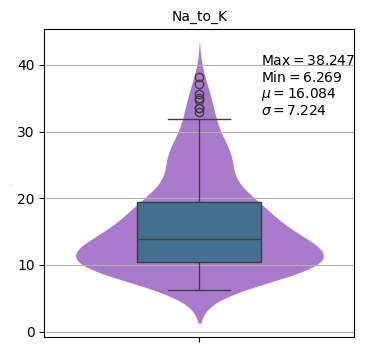

In [10]:
fig=plt.figure(figsize=(4,4))
ax=fig.add_subplot(1,1,1)

ax_violin = sns.violinplot(df['Na_to_K'], color="#af52f4", inner=None, linewidth=0, saturation=0.5,ax=ax)
sns.boxplot(df['Na_to_K'], saturation=0.5, width=0.4, boxprops={'zorder': 2}, ax=ax_violin)

plt.title('Na_to_K',fontsize=10)
plt.ylabel([],fontsize=0)
plt.grid(axis='y')

plt.text(0.2, 40, f"Max"+r'$ = $'+f"{df['Na_to_K'].max()}")
plt.text(0.2, 37.5, f"Min"+r'$ = $'+f"{df['Na_to_K'].min()}")
plt.text(0.2, 35, r'$\mu = $'+f"{round(df['Na_to_K'].mean(),3)}")
plt.text(0.2, 32.5, r'$\sigma = $'+f"{round(df['Na_to_K'].std(),3)}")

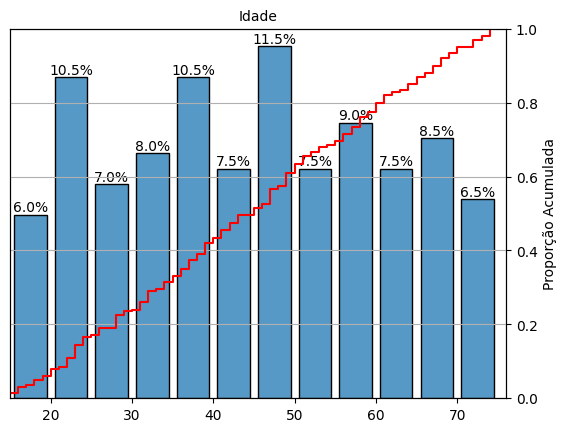

In [11]:
bins=np.arange(15, 80, 5)
ax = sns.histplot(df['Age'], shrink=.8, bins=bins)


freq = pd.cut(df['Age'], bins=np.arange(15, 80, 5),right=False).value_counts(normalize=True).sort_index().values
percent = [f'{"%.1f" % (element*100)}%' for element in freq]

ax.bar_label(ax.containers[0],labels = percent)
plt.xlim(15,76)
plt.title('Idade',fontsize=10)
plt.ylabel('')
plt.xlabel('')
plt.yticks([])

ax2 = ax.twinx()
sns.ecdfplot(data=df, x="Age", stat="proportion",color='red',ax=ax2)
plt.ylabel('Proporção Acumulada')
plt.grid(axis='y')

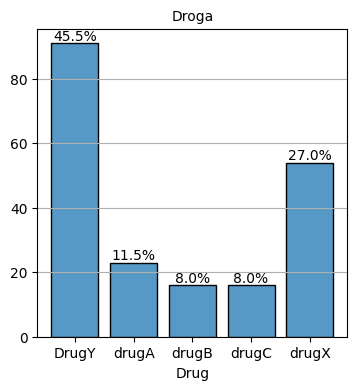

In [12]:
fig=plt.figure(figsize=(4,4))
ax = sns.histplot(df['Drug'],discrete=True, shrink=.8)
freq = df['Drug'].value_counts(normalize=True).sort_index().values
percent = [f'{"%.1f" % (element*100)}%' for element in freq]
ax.bar_label(ax.containers[0],labels = percent)
plt.title('Droga',fontsize=10)
plt.ylabel('')
plt.xticks(ticks=[0,1,2,3,4],labels=['DrugY','drugA', 'drugB', 'drugC','drugX'])
plt.grid(axis='y')


<Axes: xlabel='Na_to_K', ylabel='Drug'>

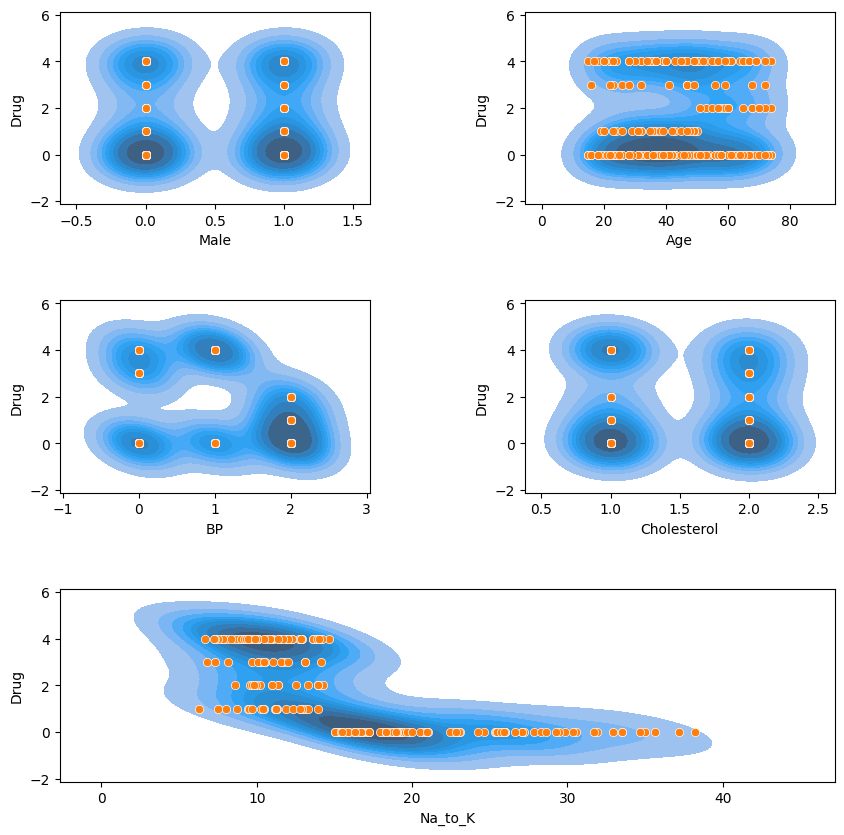

In [13]:
columns = ['Male','Age','BP','Cholesterol']

fig=plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

indice = 1
for column in columns:
    ax = fig.add_subplot(3,2,indice)
    sns.kdeplot(data=df, x=column, y="Drug", fill=True)
    sns.scatterplot(data=df, x=column, y="Drug")

    indice = indice+1

ax = fig.add_subplot(3,1,3)
sns.kdeplot(data=df, x='Na_to_K', y="Drug", fill=True)
sns.scatterplot(data=df, x='Na_to_K', y='Drug')
    

Perceba que nenhuma relação muito forte individualmente com Drug, o mais perto que temos inicialmente é a variável Na_to_K, que a partir do valor 15 temos apenas presença da drogaY.

C:\Users\Marcio B\AppData\Local\Temp\ipykernel_920\3395165598.py:10: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.kdeplot(data=df, x=columns[i], y=columns[j], hue='Drug',
C:\Users\Marcio B\AppData\Local\Temp\ipykernel_920\3395165598.py:12: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=df, x=columns[i], y=columns[j], hue='Drug',
C:\Users\Marcio B\AppData\Local\Temp\ipykernel_920\3395165598.py:10: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.kdeplot(data=df, x=columns[i], y=columns[j], hue='Drug',
C:\Users\Marcio B\AppData\Local\Temp\ipykernel_920\3395165598.py:12: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=df, x=columns[i], y=columns[j], hue='Drug',
C:\Users\Marcio B\AppData\Local\Temp\ipykernel_920\3395165598.py:10: UserWarning: Th

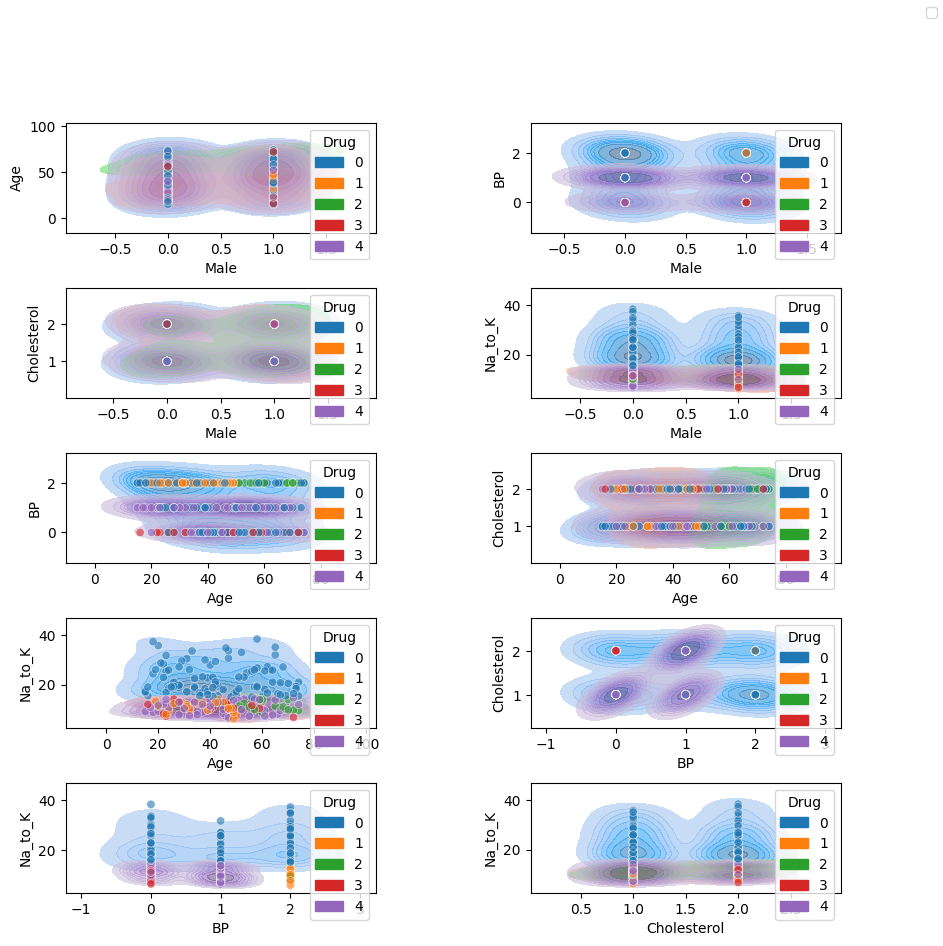

In [29]:
columns = ['Male','Age','BP','Cholesterol','Na_to_K']

fig=plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

indice = 1
for i in range(len(columns)):
    for j in range(i+1,len(columns)):
        fig.add_subplot(5,2,indice)
        sns.kdeplot(data=df, x=columns[i], y=columns[j], hue='Drug',
                    fill=True,warn_singular=False,alpha=.6,palette=sns.color_palette("tab10"))
        sns.scatterplot(data=df, x=columns[i], y=columns[j], hue='Drug',
                        palette=sns.color_palette("tab10"),legend=False,alpha=.6)

        indice = indice+1


fig.legend()


Inicialmente podemos olhar para a variável Na_to_K que sabemos que ela faz uma divisão perfeita entre uma das drogas e das demais. Analisando podemos notar que a melhor combinação de Na_to_K com outras variáveis é com BP. Percebe-se que abaixo do valor 15 de Na_to_k, no qual anteriormente não tinhamos uma divisão entre as drogas, agora temos uma divisão que visiualmente parece boa. Infelizmente não se nota nenhuma outra boa combinação entre qualquer outras duas variáveis.

In [38]:
freq = df[df['Na_to_K']<15].groupby('BP').Drug.value_counts(normalize=True)
freq

BP  Drug
0   4       0.529412
    3       0.470588
1   4       1.000000
2   1       0.589744
    2       0.410256
Name: proportion, dtype: float64

In [90]:
def visual_1(**kws):
    plt.grid(axis='y')
    plt.xticks(ticks=[0,1,2,3,4],labels=['DrugY','drugA', 'drugB', 'drugC','drugX'])


def visual_2(**kws):
    plt.grid(axis='y')

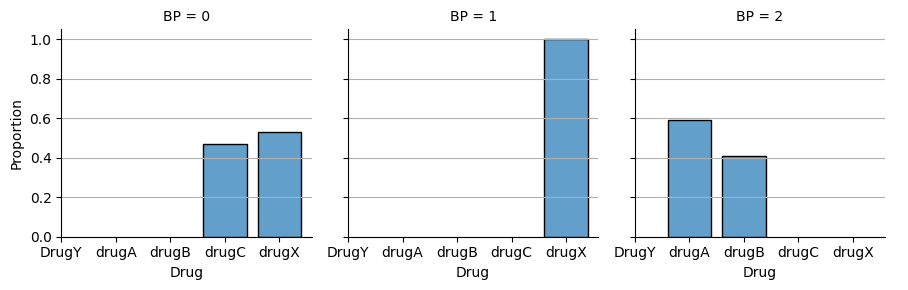

In [89]:
g = sns.FacetGrid(df[df['Na_to_K']<15], col="BP")
g.map(sns.histplot,'Drug', alpha=.7,discrete=True, shrink=.8,stat='proportion')
g.map_dataframe(visual_1)
g.add_legend()

Olhando de maneira mais detalhada para a proporção das drogas para cada valor de BP, percemos que a droga X tem uma boa divisão. Pois para BP=1 temos apenas sua presença, entretanto ainda se tem sua presença para o valor de BP=0. Infelizmente a variável droga possui uma distribuição condicional, quando BP=0, bem uniforme para as drogas C e X

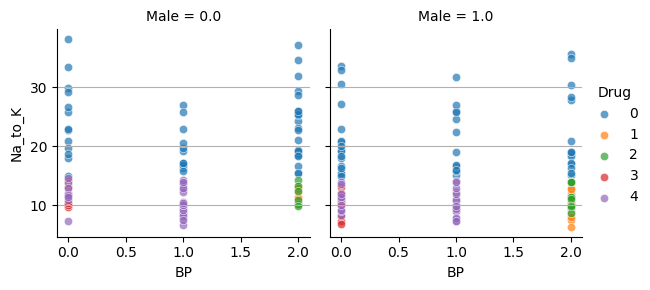

In [91]:
g = sns.FacetGrid(df, col="Male", hue="Drug")
g.map(sns.scatterplot, "BP", "Na_to_K", alpha=.7)
g.map_dataframe(visual_2)
g.add_legend()

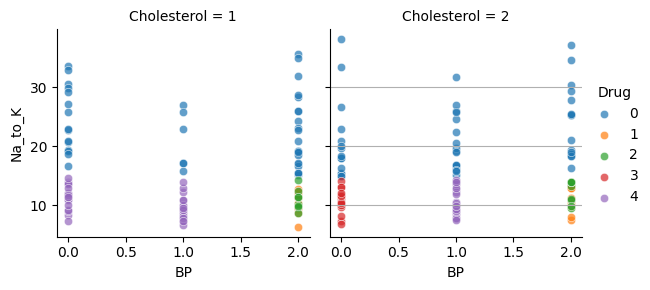

In [93]:
g = sns.FacetGrid(df, col="Cholesterol", hue="Drug")
g.map(sns.scatterplot, "BP", "Na_to_K", alpha=.7)
g.map_dataframe(visual_2)
g.add_legend()

Note que diferente da variável Male, temos que visualmente obtemos uma divisão boa dos dados quando temos BP=1, dividindo eles em roxa quando Cholesterol=1, e vermelhas para caso contrário.

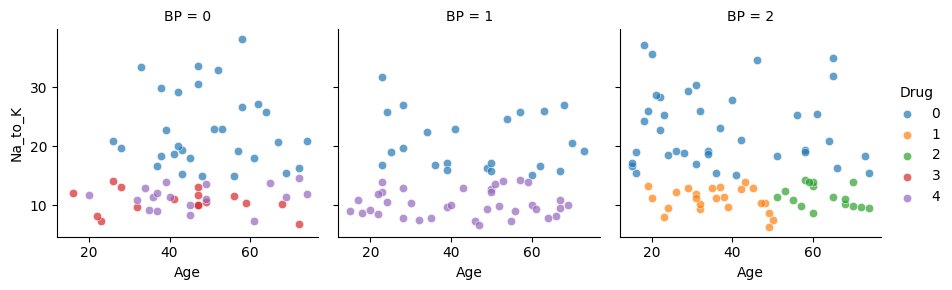

In [18]:
g = sns.FacetGrid(df, col="BP", hue="Drug")
g.map(sns.scatterplot, "Age", "Na_to_K", alpha=.7)
g.add_legend()

Igualmente Age tambem faz uma boa divisão dos dados quando BP=2

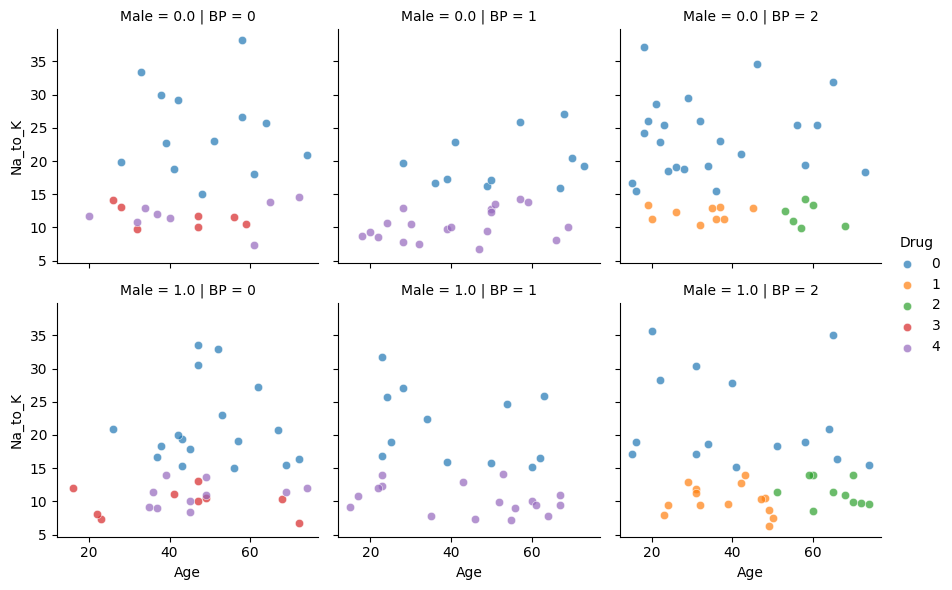

In [23]:
g = sns.FacetGrid(df, col="BP", row='Male', hue="Drug")
g.map(sns.scatterplot, "Age", "Na_to_K", alpha=.7)
g.add_legend()

Perceba que novamente a variável Male não foi capaz de separar de alguma forma os dados. Contudo, vimos anteriormente que quem faz uma boa divisão quando se tem BP=1 é a variável Cholesterol.Pode-se confirmar isso ao ver o próximo gráfico.

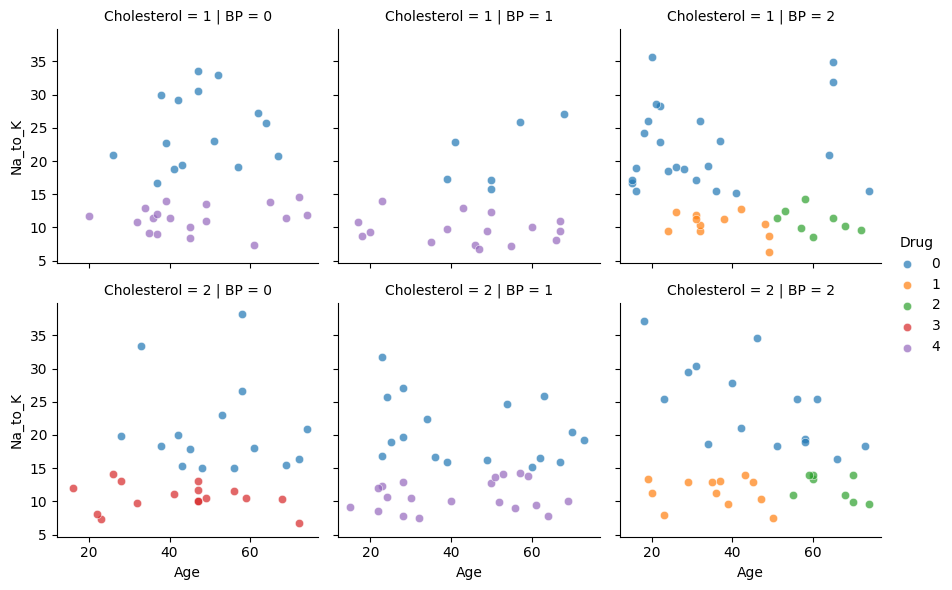

In [24]:
g = sns.FacetGrid(df, col="BP", row='Cholesterol', hue="Drug")
g.map(sns.scatterplot, "Age", "Na_to_K", alpha=.7)
g.add_legend()

In [58]:
x = df.drop(['Drug'],axis=1).values
y = df['Drug'].values
mi = fs.mutual_info_classif(x,y)

In [59]:

mi = pd.Series(mi)
mi.index =df.drop(['Drug'],axis=1).columns
mi.sort_values(ascending=False,inplace=True)

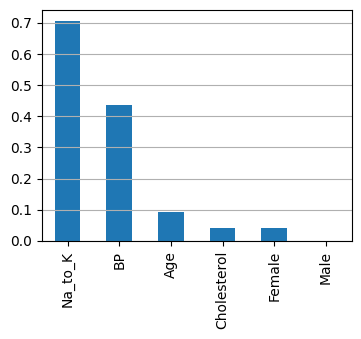

In [64]:
plt.figure(figsize=(4,3))
mi.plot.bar()
plt.grid(axis='y')

# **Pegando Melhores Parâmetros para Cada Modelo**
SVM, Random Forest, Rede Neural

## **redes neurais**

In [ ]:
parametros = {'activation': ['relu', 'logistic', 'tahn'],
              'solver': ['adam', 'sgd'],
              'batch_size': [10, 56]}

In [ ]:
grid_search = GridSearchCV(estimator=rn(), param_grid=parametros)
grid_search.fit(x_pca, y)
melhores_parametros_RN = grid_search.best_params_

In [ ]:
print(melhores_parametros_RN)

{'activation': 'relu', 'batch_size': 10, 'solver': 'adam'}


## **SVM**

In [1]:
parametros = {'tol': [0.001, 0.0001, 0.00001],
              'C': [1.0, 1.5, 2.0],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

In [ ]:
grid_search = GridSearchCV(estimator=SVC(), param_grid=parametros)
grid_search.fit(x_pca, y)
melhores_parametros_SVM = grid_search.best_params_


In [ ]:
print(melhores_parametros_SVM)

##**Random Forest**

In [ ]:
parametros = {'criterion': ['gini', 'entropy'],
              'n_estimators': [10, 40, 100, 150],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 5, 10]}

In [ ]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametros)
grid_search.fit(x_pca, y)
melhores_parametros_RF = grid_search.best_params_


In [ ]:
print(melhores_parametros_RF)

{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


# **Comparação de Modelos**
SVM, Random Forest, Rede Neural

In [ ]:
resultados_rede_neural = []
resultados_random_forest = []
resultados_svm = []


for i in range(60):

    kfold = KFold(n_splits=10, shuffle=True, random_state=i)


    random_forest = RandomForestClassifier(
              criterion = melhores_parametros_RF['criterion'],
              n_estimators = melhores_parametros_RF['n_estimators'],
              min_samples_split = melhores_parametros_RF['min_samples_split'],
              min_samples_leaf = melhores_parametros_RF['min_samples_leaf']
              )
    scores = cross_val_score(random_forest, x_pca, y, cv = kfold)
    resultados_random_forest.append(scores.mean())


    svm = SVC(
            tol = melhores_parametros_SVM['tol'],
            C = melhores_parametros_SVM['C'],
            kernel = melhores_parametros_SVM['kernel']
            )
    scores = cross_val_score(svm, x_pca, y, cv = kfold)
    resultados_svm.append(scores.mean())


    rede_neural = rn(
              activation = melhores_parametros_RN['activation'],
              solver = melhores_parametros_RN['solver'],
              batch_size = melhores_parametros_RN['batch_size']
               )
    scores = cross_val_score(rede_neural, x_pca, y, cv = kfold)
    resultados_rede_neural.append(scores.mean())


In [ ]:
resultados = pd.DataFrame({'Random forest': resultados_random_forest,
                           'SVM': resultados_svm,
                           'Rede neural': resultados_rede_neural})
resultados.head(5)

,Random forest,SVM,Rede neural
0,0.875,0.770,0.930
1,0.855,0.775,0.915
2,0.885,0.775,0.945
3,0.860,0.795,0.915
4,0.860,0.785,0.920


In [ ]:
resultados.describe()

,Random forest,SVM,Rede neural
count,60.000000,60.000000,60.000000
mean,0.870250,0.789667,0.926000
std,0.012737,0.012851,0.010325
min,0.830000,0.755000,0.895000
25%,0.860000,0.780000,0.920000
50%,0.870000,0.790000,0.925000
75%,0.880000,0.800000,0.930000
max,0.895000,0.815000,0.950000


In [ ]:
print('Coeficiente de Variação')
(resultados.std() / resultados.mean()) * 100

Coeficiente de Variação


Random forest    1.463573
SVM              1.627361
Rede neural      1.115035
dtype: float64

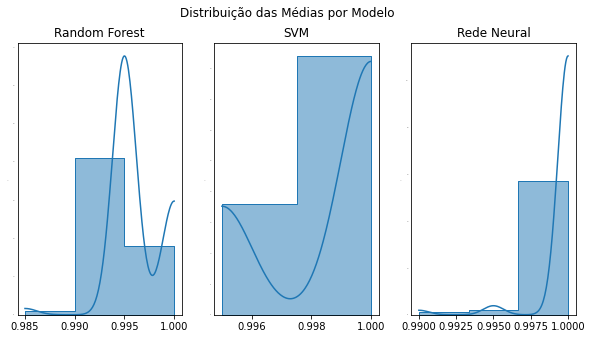

In [ ]:
fig=plt.figure(figsize=(10,5))
fig.suptitle('Distribuição das Médias por Modelo')


ax = fig.add_subplot(1,3,1)
ax.set_title('Random Forest')
sns.histplot(resultados_random_forest, bins=len(pd.Series(resultados_random_forest).unique()), kde=True, element='step')
plt.ylabel([], fontsize=0)
plt.tick_params(axis='y', labelsize=0, length=0)

ax = fig.add_subplot(1,3,2)
ax.set_title('SVM')
sns.histplot(resultados_svm, bins=len(pd.Series(resultados_svm).unique()), kde=True, element='step')
plt.ylabel([], fontsize=0)
plt.tick_params(axis='y', labelsize=0, length=0)

ax = fig.add_subplot(1,3,3)
ax.set_title('Rede Neural')
sns.histplot(resultados_rede_neural, bins=len(pd.Series(resultados_rede_neural).unique()), kde=True, element='step')
plt.ylabel([], fontsize=0)
plt.tick_params(axis='y', labelsize=0, length=0)

In [ ]:
alpha=0.05

In [ ]:
p={}
_,p['Random Forest'] = shapiro(resultados_random_forest)
_,p['SVM'] = shapiro(resultados_svm)
_,p['Rede Neural'] = shapiro(resultados_rede_neural)
for i in p:
    if p[i] <= alpha:
        print(f'Média amostral de {i} não segue uma normal')
    else:
        print(f'Média amostral de {i} segue uma normal')

Média amostral de Random Forest não segue uma normal
Média amostral de SVM não segue uma normal
Média amostral de Rede Neural não segue uma normal


In [ ]:
classificador_rede_neural = rn(
              activation = melhores_parametros_RN['activation'],
              solver = melhores_parametros_RN['solver'],
              batch_size = melhores_parametros_RN['batch_size']
              )
classificador_rede_neural.fit(x_pca, y)



classificador_svm = SVC(
            tol = melhores_parametros_SVM['tol'],
            C = melhores_parametros_SVM['C'],
            kernel = melhores_parametros_SVM['kernel']
            )
classificador_svm.fit(x_pca, y)



classificador_random_forest = RandomForestClassifier(
              criterion = melhores_parametros_RF['criterion'],
              n_estimators = melhores_parametros_RF['n_estimators'],
              min_samples_split = melhores_parametros_RF['min_samples_split'],
              min_samples_leaf = melhores_parametros_RF['min_samples_leaf']
              )

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


# **Matriz de confusão**

Text(0.5, 0, 'Valor Predito')

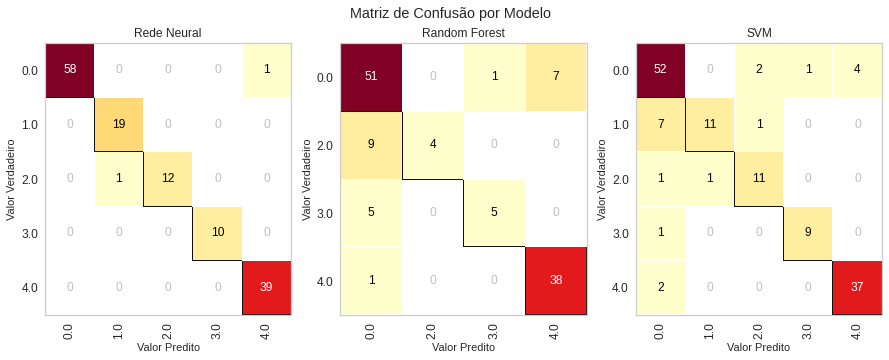

In [ ]:
fig=plt.figure(figsize=(15,5))
fig.suptitle('Matriz de Confusão por Modelo')


ax = fig.add_subplot(1,3,1)
ax.set_title('Rede Neural')
X_train, X_test, y_train, y_test = train_test_split(
        x_pca, y, test_size=0.7, random_state=42
    )
cm=ConfusionMatrix(classificador_rede_neural)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)
plt.ylabel('Valor Verdadeiro')
plt.xlabel('Valor Predito')


ax = fig.add_subplot(1,3,2)
ax.set_title('Random Forest')
X_train, X_test, y_train, y_test = train_test_split(
        x_pca, y, test_size=0.7, random_state=42
    )
cm=ConfusionMatrix(classificador_random_forest)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)
plt.ylabel('Valor Verdadeiro')
plt.xlabel('Valor Predito')


ax = fig.add_subplot(1,3,3)
ax.set_title('SVM')
X_train, X_test, y_train, y_test = train_test_split(
        x_pca, y, test_size=0.7, random_state=42
    )
cm=ConfusionMatrix(classificador_svm)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)
plt.ylabel('Valor Verdadeiro')
plt.xlabel('Valor Predito')

# **Exportando Modelos**

In [ ]:
pickle.dump(classificador_rede_neural, open('rede_neural_finalizado.sav', 'wb'))

pickle.dump(classificador_svm, open('svm_finalizado.sav', 'wb'))

pickle.dump(classificador_random_forest, open('random_forest_finalizado.sav', 'wb'))